In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'customer-segmentation-tutorial-in-python' dataset.
Path to dataset files: /kaggle/input/customer-segmentation-tutorial-in-python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted')
%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
X.columns = ['Income', 'SpendingScore']
X.head()

,Income,SpendingScore
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


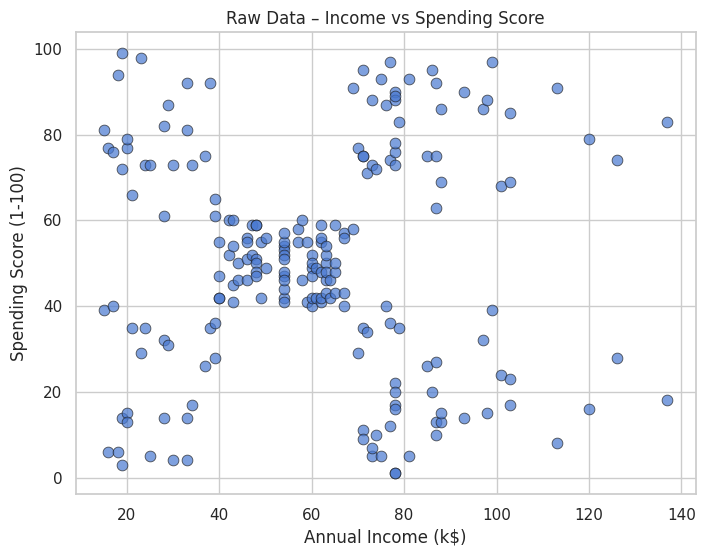

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=X, x='Income', y='SpendingScore', s=60, edgecolor='k', alpha=0.7)
plt.title('Raw Data – Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Income,SpendingScore
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


In [12]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

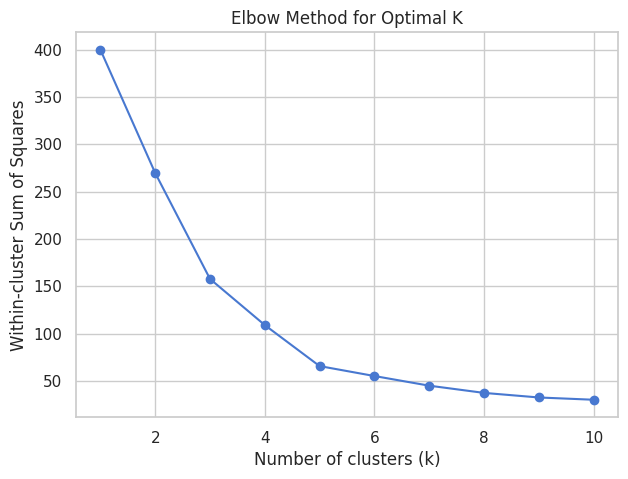

In [13]:
plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, 'bo-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.grid(True)
plt.show()

In [14]:
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

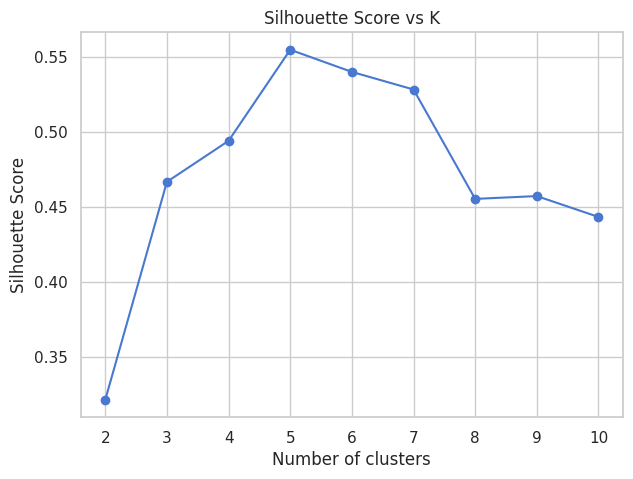

In [20]:
plt.figure(figsize=(7,5))
plt.plot(range(2,11), sil_scores, 'o-')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [21]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [22]:
df['Cluster'] = clusters
X['Cluster'] = clusters

<Axes: xlabel='Income', ylabel='SpendingScore'>

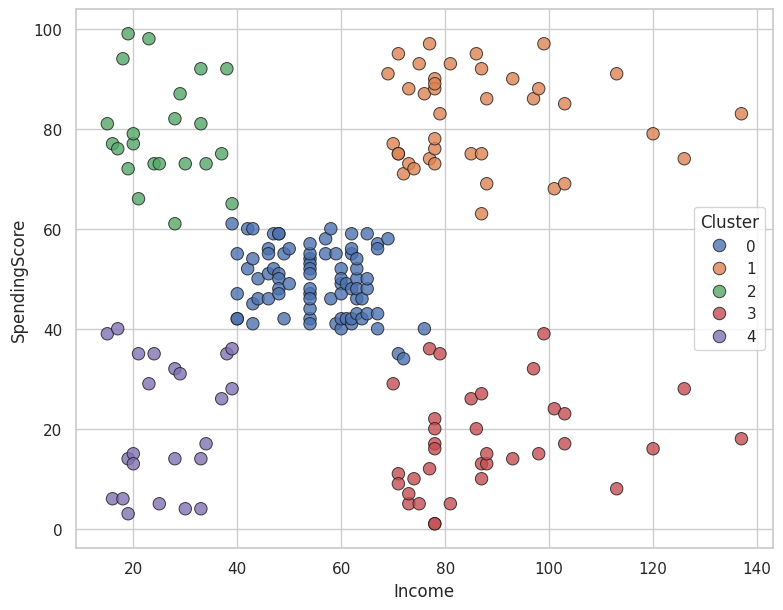

In [23]:
plt.figure(figsize=(9,7))
palette = sns.color_palette('deep', optimal_k)
sns.scatterplot(data=X, x='Income', y='SpendingScore', hue='Cluster',
                palette=palette, s=80, edgecolor='k', alpha=0.8, legend='full')

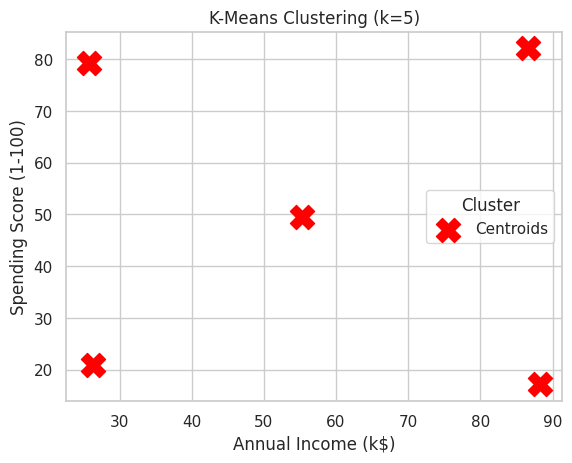

In [26]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], s=300, c='red', marker='X', label='Centroids')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

In [27]:
cluster_summary = (df.groupby('Cluster')
                   .agg(Avg_Income=('Annual Income (k$)', 'mean'),
                        Avg_Spending=('Spending Score (1-100)', 'mean'),
                        Count=('CustomerID', 'count'))
                   .round(2))
cluster_summary

,Avg_Income,Avg_Spending,Count
Cluster,,,
0,55.30,49.52,81
1,86.54,82.13,39
2,25.73,79.36,22
3,88.20,17.11,35
4,26.30,20.91,23


In [28]:
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)

In [29]:
n_noise = list(db_labels).count(-1)
print(f"DBSCAN found {len(set(db_labels))- (1 if -1 in db_labels else 0)} clusters "
      f"and {n_noise} noise points.")

df['DBSCAN_Cluster'] = db_labels

DBSCAN found 2 clusters and 8 noise points.


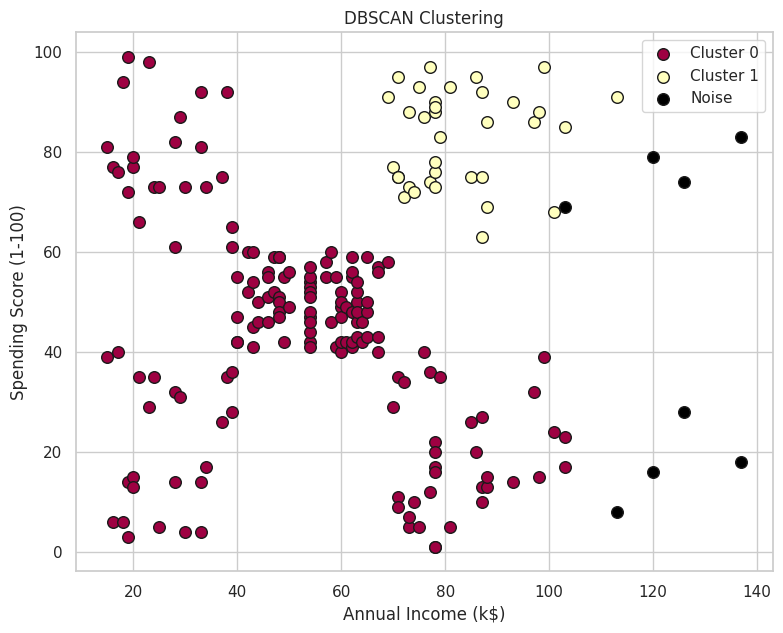

In [30]:
plt.figure(figsize=(9,7))
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for lbl, col in zip(unique_labels, colors):
    if lbl == -1:
        col = [0, 0, 0, 1]
    mask = db_labels == lbl
    plt.scatter(X.loc[mask, 'Income'], X.loc[mask, 'SpendingScore'],
                c=[col], s=70, edgecolor='k', label=f'Cluster {lbl}' if lbl != -1 else 'Noise')
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [32]:
db_summary = (df[df['DBSCAN_Cluster'] != -1]
              .groupby('DBSCAN_Cluster')
              .agg(Avg_Income=('Annual Income (k$)', 'mean'),
                   Avg_Spending=('Spending Score (1-100)', 'mean'),
                   Count=('CustomerID', 'count'))
              .round(2))

In [33]:
print("=--- K-Means Summary ---")
display(cluster_summary)

=--- K-Means Summary ---


,Avg_Income,Avg_Spending,Count
Cluster,,,
0,55.30,49.52,81
1,86.54,82.13,39
2,25.73,79.36,22
3,88.20,17.11,35
4,26.30,20.91,23


In [34]:
print("--- DBSCAN Summary (noise excluded) ---")
display(db_summary)

--- DBSCAN Summary (noise excluded) ---


,Avg_Income,Avg_Spending,Count
DBSCAN_Cluster,,,
0,52.49,43.1,157
1,82.54,82.8,35
